In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from src.data import load_categories, load_hills, load_glove_model, load_word_frequency

hills_csv       = load_hills('../data/hills.csv')
reba_categories = load_categories('../data/reba_categories.csv')
word_freq       = load_word_frequency('../data/word_frequency.csv')
glove_model     = load_glove_model('../data/glove/glove.6B.300d.txt')

Loading GloVe...


400000it [00:10, 39869.62it/s]

400000 words loaded!


In [4]:
from src.data import preprocess_hills
from src.switch import adjudicate_categorization

hills = preprocess_hills(hills_csv, glove_model, reba_categories)
reba_adj = adjudicate_categorization(reba_categories, hills)

In [6]:
from src.tree import create_animal_graph

# (Optional) Override word frequency by using hills data
resp = [i for j in [r['response'] for r in hills] for i in j]
word_freq = {r: 100 * resp.count(r)/len(resp) for r in resp}

EPSILON = 0.4
G = create_animal_graph(reba_categories.keys(), glove_model, word_freq, EPSILON)

In [1]:
# Make sure to initialize LLM endpoint
PORT = 8260

### LLM Exemplar Generation

In [8]:
from src.llm import generate_endpoint, FLUENCY_PROMPT
from src.search import remove_dupliates
from src.util import calculate_entropy
import torch
import torch.nn.functional as F

previous_seq = hills[0]['response'][:5]

exemplar, log_probs = generate_endpoint(previous_seq, prompt=FLUENCY_PROMPT, port=PORT)
llm_probs = F.softmax(torch.tensor(log_probs, dtype=torch.float32), dim=0)
exemplar, llm_probs = remove_dupliates(exemplar, llm_probs)
exemplar, llm_probs = [e for e in exemplar if e in reba_categories.keys()], [round(p.item(), 4) for i, p in enumerate(llm_probs) if exemplar[i] in reba_categories.keys()]

print(exemplar)
print(llm_probs)
print(calculate_entropy(llm_probs).item())

['elephant', 'whale', 'chimpanzee', 'monkey', 'snake', 'zebra', 'lion', 'penguin', 'tiger', 'rabbit', 'kangaroo', 'owl', 'koala', 'bear', 'wolf', 'otter', 'octopus', 'eagle', 'horse', 'crocodile', 'cheetah', 'fish', 'python', 'hippopotamus', 'shark', 'sloth', 'bird']
[0.4403, 0.1269, 0.0732, 0.0568, 0.055, 0.0396, 0.0298, 0.027, 0.0148, 0.0143, 0.0116, 0.0109, 0.0103, 0.0102, 0.009, 0.007, 0.0067, 0.006, 0.0058, 0.0056, 0.0053, 0.0039, 0.0038, 0.0037, 0.0036, 0.003, 0.0028]
3.073960781097412


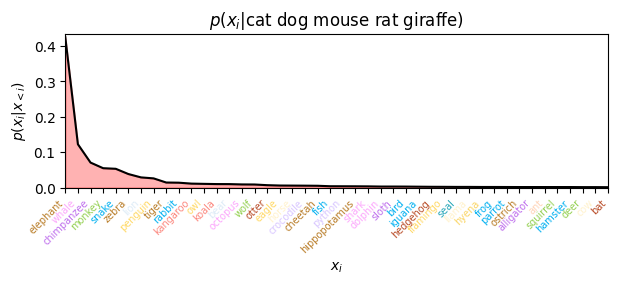

In [15]:
import matplotlib.pyplot as plt
from src.data import REBA_CATEGORY_COLORS

x, y = exemplar, llm_probs

colors = [REBA_CATEGORY_COLORS[c] for c in [reba_adj[exemplar] for exemplar in x]]

plt.figure(figsize=(7, 2))
plt.plot(x, y, color='black')
plt.fill_between(x, y, color='red', alpha=0.3)
plt.ylim(0, max(y) + 0.01)
plt.xlim(0, len(x) - 1)
plt.xticks(rotation=45, fontsize=7, ha='right')
plt.xlabel(r'$x_i$')
plt.ylabel(r'$p(x_i|x_{<i})$')
plt.title(f'$p(x_i|\\text{{{" ".join(previous_seq)}}})$')

for i, label in enumerate(plt.gca().xaxis.get_ticklabels()):
    label.set_color(colors[i])

plt.show()

### Recover Next-Exemplar Probobability Distribution

In [9]:
from src.search import llm_step

llm_step(G, ['dog', 'cat', 'mouse'], 1, 1, PORT)

{'cat': 0.7839670608149217,
 'rabbit': 0.11384390519240543,
 'bunny': 0.08908716600169564,
 'monkey': 0.007551122238118963,
 'rat': 0.002818988318662853,
 'squirrel': 0.0015449061588896048,
 'frog': 0.0011868512753058385}

In [ ]:
from tqdm import tqdm
import numpy as np

BETA_L, BETA_G = 1, 1

for i, run in tqdm(enumerate(hills)):
    cue_probs = [0]
    for j, r in enumerate(run['response'][1:]):
        prefix = run['response'][:j+1]
        try:
            next_node = llm_step(G, prefix, BETA_L, BETA_G, PORT)
        except Exception as e:
            print(f'Failed on {prefix}, received error "{e}". Skipping...')
            cue_probs += [float('nan')]
            continue

        if run['response'][j] in next_node.keys():
            cue_probs += [next_node[run['response'][j]]]
        else:
            cue_probs += [float('nan')]
    hills[i]['llm_cue_probs'] = np.asarray(cue_probs)

### IRT Prediction using LLM Entropy

In [5]:
from src.util import calculate_entropy
import numpy as np
import json

PRE_COMPUTED_ENTROPY = '../data/entropy.json'

with open(PRE_COMPUTED_ENTROPY, 'r', encoding='utf-8') as f:
    data = json.load(f)
    for i, run in enumerate(data):
        assert run['participant'] == hills[i]['participant']
        if len(run['llm_cue_probs']) != len(hills[i]['response']):
            run['llm_cue_probs'] = run['llm_cue_probs'][:-1]
        assert len(run['llm_cue_probs']) == len(hills[i]['response'])
        hills[i]['llm_cue_probs'] = run['llm_cue_probs']

# Calculate entropy for LLM prediction
for i, run in enumerate(hills):
    probs = [list(prob.values()) if type(prob) == dict else [] for prob in run['llm_cue_probs']]
    entropy = []
    for p in probs:
        if len(p) != 0:
            entropy += [calculate_entropy(p).item()]
        else:
            entropy += [float('nan')]
    hills[i]['llm_entropy'] = entropy

# Calculate probability of next exemplar within LLM distribution
for i, run in enumerate(hills):
    cue_probs = [0]
    for j, r in enumerate(run['response'][1:]):
        next_node = hills[i]['llm_cue_probs'][j-1]
        if next_node is not None and run['response'][j] in next_node.keys():
            cue_probs += [next_node[run['response'][j]]]
        else:
            cue_probs += [float('nan')]
    assert len(hills[i]['response']) == len(cue_probs)
    hills[i]['llm_next_exemplar_prob'] = np.asarray(cue_probs)    

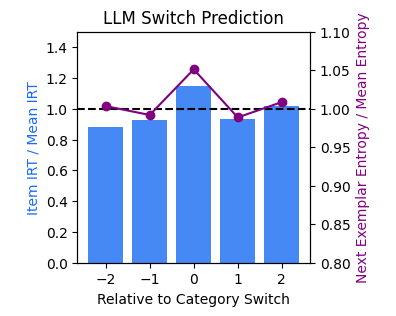

In [11]:
import matplotlib.pyplot as plt
from src.switch import get_mean_heuristic

mean_irt = get_mean_heuristic(hills, heuristic_col='irt', switch_col='switch_adj')
mean_llm_entropy = get_mean_heuristic(hills, heuristic_col='llm_entropy', switch_col='switch_adj')
# mean_next_exemplar_prob = get_mean_heuristic(hills, heuristic_col='llm_next_exemplar_prob', switch_col='switch_adj')

fig, ax1 = plt.subplots(figsize=(3, 3))

ax1.bar(range(-2, 3), mean_irt, color='#186cf2', alpha=0.8)
ax1.axhline(y=1, color='k', linestyle='--')
ax1.set_xticks(range(-2, 3))
ax1.set_ylim(0, 1.5)
ax1.set_xlabel('Relative to Category Switch')
ax1.set_ylabel('\nItem IRT / Mean IRT', color='#186cf2')

ax2 = ax1.twinx()
ax2.plot(range(-2, 3), mean_llm_entropy, color='purple', marker='o')
ax2.set_ylim(0.8, 1.1)
ax2.set_ylabel('Next Exemplar Entropy / Mean Entropy\n', color='purple')

plt.title('LLM Switch Prediction')

out_filename = "img/llm_switch.pdf"
plt.savefig(out_filename, format="pdf", bbox_inches='tight', pad_inches=0.0, dpi=300)

plt.show()

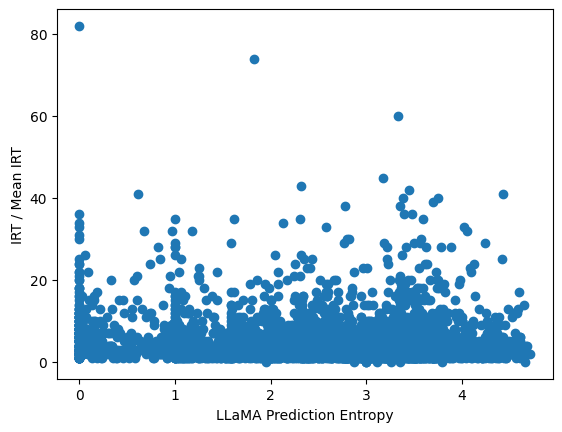

In [89]:
import matplotlib.pyplot as plt

xs, ys = [i for j in [r['llm_entropy'] for r in hills] for i in j], [i for j in [r['irt'] for r in hills] for i in j]

plt.scatter(xs, ys)
plt.xlabel('LLaMA Prediction Entropy')
plt.ylabel('IRT / Mean IRT')
plt.show()

### Full Sequence Generation

In [7]:
from src.evaluate import evaluate_results
from src.search import graph_traversal, llm_step
from tqdm import tqdm

N_ITER = 3

beta_g = 1
beta_ls = [0, 1e-5, 5e-5, 1e-4, 5e-4, 0.01, 0.1, 0.5, 1, 2, 5]

results = {}
preds = {}

for beta_l in beta_ls:
    print(f'Evaluing at beta_l: {beta_l}')
    def traversal_func(graph, sequence, current_node):
        sequence = sequence[:-1] + [current_node]
        return llm_step(graph, sequence, beta_l, beta_g, PORT, category_map=reba_categories)

    gold = [r['response'] for r in hills]
    pred = []
    for _ in tqdm(range(N_ITER)):
        pred += [graph_traversal(G, traversal_func, traversal_method='sample', max_iter=40)]

    preds[beta_l] = pred
    results[beta_l] = evaluate_results(pred, gold, reba_categories)

Evaluing at beta_l: 0


100%|██████████| 3/3 [11:03<00:00, 221.19s/it]


Evaluing at beta_l: 1e-05


100%|██████████| 3/3 [10:55<00:00, 218.52s/it]


Evaluing at beta_l: 5e-05


100%|██████████| 3/3 [10:36<00:00, 212.27s/it]


Evaluing at beta_l: 0.0001


100%|██████████| 3/3 [10:40<00:00, 213.47s/it]


Evaluing at beta_l: 0.0005


100%|██████████| 3/3 [10:39<00:00, 213.24s/it]


Evaluing at beta_l: 0.01


100%|██████████| 3/3 [10:33<00:00, 211.29s/it]


Evaluing at beta_l: 0.1


100%|██████████| 3/3 [11:03<00:00, 221.30s/it]


Evaluing at beta_l: 0.5


100%|██████████| 3/3 [10:58<00:00, 219.37s/it]


Evaluing at beta_l: 1


100%|██████████| 3/3 [10:56<00:00, 218.81s/it]


Evaluing at beta_l: 2


100%|██████████| 3/3 [10:39<00:00, 213.16s/it]


Evaluing at beta_l: 5


100%|██████████| 3/3 [10:45<00:00, 215.30s/it]


In [8]:
for beta_l, p in sorted(preds.items()):
    print(beta_l)
    print(p[0][:10])

0
['zebra', 'leopard', 'tiger', 'elephant', 'bear', 'lion', 'wolf', 'deer', 'rat', 'mouse']
1e-05
['bear', 'dog', 'horse', 'elephant', 'panda', 'orangutan', 'gorilla', 'monkey', 'cat', 'kitten']
5e-05
['orangutan', 'koala', 'grizzly', 'moose', 'squirrel', 'chipmunk', 'monkey', 'cat', 'dog', 'horse']
0.0001
['elephant', 'cow', 'bird', 'fish', 'squid', 'whale', 'shark', 'tiger', 'leopard', 'cat']
0.0005
['whale', 'dolphin', 'turtle', 'frog', 'snake', 'eel', 'shrimp', 'lobster', 'fish', 'bird']
0.01
['mouse', 'bunny', 'duck', 'pig', 'dog', 'monkey', 'cat', 'rabbit', 'goat', 'elephant']
0.1
['crocodile', 'alligator', 'turtle', 'fish', 'whale', 'dolphin', 'shark', 'tiger', 'elephant', 'monkey']
0.5
['goose', 'elk', 'moose', 'coyote', 'deer', 'sheep', 'cow', 'pig', 'monkey', 'frog']
1
['hamster', 'gerbil', 'horse', 'camel', 'sheep', 'bison', 'moose', 'coyote', 'bobcat', 'grizzly']
2
['elephant', 'goat', 'pig', 'cattle', 'hog', 'elk', 'raccoon', 'boar', 'ox', 'bull']
5
['meerkat', 'octopus', 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

beta_l, exemplar_bleu = [], []
for k, v in sorted(results.items()):
    if k == 0:
        continue
    beta_l += [k]
    exemplar_bleu += [v['exemplar_bleu']]

plt.figure(figsize=(4, 2))
plt.semilogx(beta_l, exemplar_bleu, marker='o', linestyle='-', color='blue')
# plt.plot(beta_l, exemplar_bleu, marker='o', linestyle='-', color='blue')

plt.title('LLM Performance w/ Global Cue')
plt.xlabel(r'$\beta_l/\beta_g$')
plt.ylabel('Exemplar BLEU')
plt.grid(True)

plt.xlim(5e-6, 1e1)
plt.ylim(-0.01, 0.21)
# plt.yticks(np.arange(0, 0.15, 0.025))
plt.yticks(np.arange(0, 0.25, 0.05))

out_filename = "img/llm_cue_strength.pdf"
plt.savefig(out_filename, format="pdf", bbox_inches='tight', pad_inches=0, dpi=300)

plt.show()

### LLM Entropy Figure

In [181]:
from src.llm import generate_endpoint, FLUENCY_PROMPT
from src.search import remove_dupliates
from src.util import calculate_entropy
from tqdm import tqdm
import torch
import torch.nn.functional as F

seq = hills[0]['response']

entropies = []
for i in tqdm(range(min(30, len(seq)))):
    previous_seq = seq[:i]

    exemplar, log_probs = generate_endpoint(previous_seq, prompt=FLUENCY_PROMPT, port=PORT)
    llm_probs = F.softmax(torch.tensor(log_probs, dtype=torch.float32), dim=0)
    exemplar, llm_probs = remove_dupliates(exemplar, llm_probs)
    exemplar, llm_probs = [e for e in exemplar if e in reba_categories.keys()], [round(p.item(), 4) for i, p in enumerate(llm_probs) if exemplar[i] in reba_categories.keys()]

    entropies += [calculate_entropy(llm_probs).item()]

100%|██████████| 30/30 [02:24<00:00,  4.80s/it]


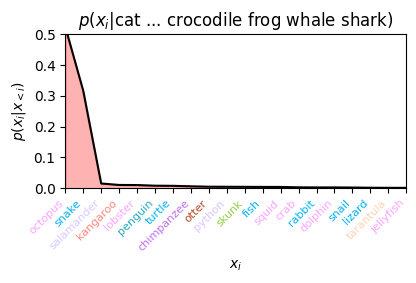

In [182]:
import matplotlib.pyplot as plt
import numpy as np
from src.data import REBA_CATEGORY_COLORS

# Re-do calculation on highest entropy in sequence
max_idx = np.asarray(entropies[1:]).argmin() + 1
previous_seq = seq[:max_idx]

exemplar, log_probs = generate_endpoint(previous_seq, prompt=FLUENCY_PROMPT, port=PORT)
llm_probs = F.softmax(torch.tensor(log_probs, dtype=torch.float32), dim=0)
exemplar, llm_probs = remove_dupliates(exemplar, llm_probs)
exemplar, llm_probs = [e for e in exemplar if e in reba_categories.keys()], [round(p.item(), 4) for i, p in enumerate(llm_probs) if exemplar[i] in reba_categories.keys()]

x, y = exemplar, llm_probs

colors = [REBA_CATEGORY_COLORS[c] for c in [reba_adj[exemplar] for exemplar in x]]

plt.figure(figsize=(4.4, 2))
plt.plot(x, y, color='black')
plt.fill_between(x, y, color='red', alpha=0.3)
# plt.ylim(0, max(y) + 0.01)
plt.ylim(0, 0.5)
plt.xlim(0, len(x) - 1)
plt.yticks(np.arange(0, 0.6, 0.1))
plt.xticks(rotation=45, fontsize=8, ha='right')
plt.xlabel(r'$x_i$')
plt.ylabel(r'$p(x_i|x_{<i})$')
seq_text = [previous_seq[0]] + ['...'] + previous_seq[-4:]
plt.title(f'$p(x_i|\\text{{{" ".join(seq_text)}}})$')

for i, label in enumerate(plt.gca().xaxis.get_ticklabels()):
    label.set_color(colors[i])

out_filename = "img/llm_dist.png"
plt.savefig(out_filename, format="png", bbox_inches='tight', pad_inches=0.1, dpi=300)

plt.show()

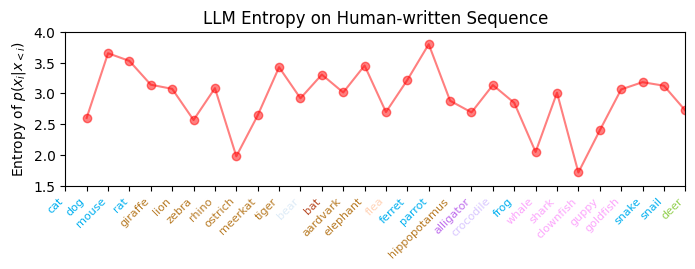

In [183]:
x, y = seq[:len(entropies)], entropies

colors = [REBA_CATEGORY_COLORS[c] for c in [reba_adj[exemplar] for exemplar in x]]

plt.figure(figsize=(8, 2))
plt.plot(x, [None] + y[1:], marker='o', linestyle='-', color='red', alpha=0.5)
plt.xlim(0, len(x) - 1)
plt.ylim(1.5, 4)
plt.xticks(x, rotation=45, fontsize=8, ha='right')
# plt.xlabel("Human Exemplar")
plt.ylabel(r'Entropy of $p(x_i|x_{<i})$')
plt.title("LLM Entropy on Human-written Sequence")

for i, label in enumerate(plt.gca().xaxis.get_ticklabels()):
    label.set_color(colors[i])

out_filename = "img/llm_dist.png"
plt.savefig(out_filename, format="png", bbox_inches='tight', pad_inches=0.1, dpi=300)

plt.show()

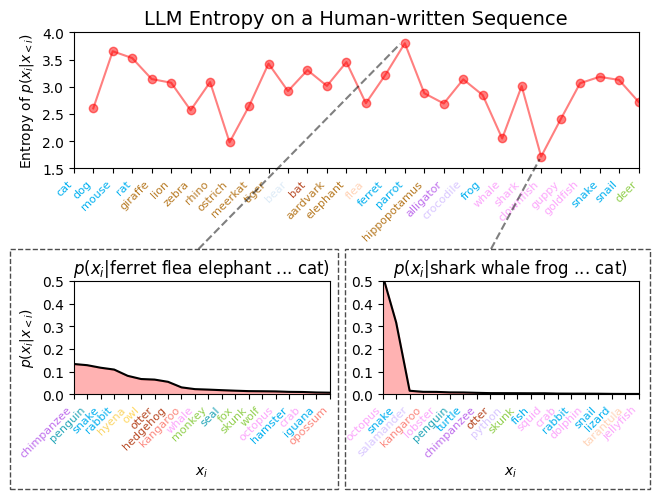

In [214]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
import numpy as np
from src.data import REBA_CATEGORY_COLORS

fig = plt.figure(figsize=(6.5, 5))
gs = gridspec.GridSpec(2, 2, height_ratios=[1.2, 1], width_ratios=[1, 1])


# Top Figures
ax0 = plt.subplot(gs[0, :])
x, y = seq[:len(entropies)], entropies
colors = [REBA_CATEGORY_COLORS[c] for c in [reba_adj[exemplar] for exemplar in x]]
ax0.plot(x, [None] + y[1:], marker='o', linestyle='-', color='red', alpha=0.5)
ax0.set_xlim(0, len(x) - 1)
ax0.set_ylim(1.5, 4)
ax0.set_xticks(range(len(x)))
ax0.set_yticks(np.arange(1.5, 4.5, 0.5))
ax0.set_xticklabels(x, rotation=45, fontsize=8, ha='right')
ax0.set_ylabel(r'Entropy of $p(x_i|x_{<i})$')
ax0.set_title("LLM Entropy on a Human-written Sequence", fontsize=14)

for i, label in enumerate(plt.gca().xaxis.get_ticklabels()):
    label.set_color(colors[i])

# Bottom Figures

# Re-do calculation on highest entropy in sequence
min_idx = np.asarray(entropies[1:]).argmin() + 1
max_idx = np.asarray(entropies[1:]).argmax() + 1

def get_prob_dist(previous_seq, LIMIT=20):
    exemplar, log_probs = generate_endpoint(previous_seq, prompt=FLUENCY_PROMPT, port=PORT)
    llm_probs = F.softmax(torch.tensor(log_probs, dtype=torch.float32), dim=0)
    exemplar, llm_probs = remove_dupliates(exemplar, llm_probs)
    exemplar, llm_probs = [e for e in exemplar if e in reba_categories.keys()], [round(p.item(), 4) for i, p in enumerate(llm_probs) if exemplar[i] in reba_categories.keys()]
    return exemplar[:LIMIT], llm_probs[:LIMIT]

ax1 = plt.subplot(gs[1, 0])

previous_seq = seq[:max_idx]
# xmax, ymax = get_prob_dist(previous_seq)
x, y = xmax, ymax
colors = [REBA_CATEGORY_COLORS[c] for c in [reba_adj[exemplar] for exemplar in x]]
ax1.plot(x, y, color='black')
ax1.fill_between(x, y, color='red', alpha=0.3)
ax1.set_ylim(0, 0.5)
ax1.set_xlim(0, len(x) - 1)
ax1.set_yticks(np.arange(0, 0.6, 0.1))
ax1.set_xticks(range(len(x)))
ax1.set_xticklabels(x, rotation=45, fontsize=8, ha='right')
ax1.set_xlabel(r'$x_i$')
ax1.set_ylabel(r'$p(x_i|x_{<i})$')
seq_text = previous_seq[-1:-4:-1] + ['...'] + [previous_seq[0]]
ax1.set_title(f'$p(x_i|\\text{{{" ".join(seq_text)}}})$')

for i, label in enumerate(plt.gca().xaxis.get_ticklabels()):
    label.set_color(colors[i])


ax2 = plt.subplot(gs[1, 1])

previous_seq = seq[:min_idx]
# xmin, ymin = get_prob_dist(previous_seq)
x, y = xmin, ymin
colors = [REBA_CATEGORY_COLORS[c] for c in [reba_adj[exemplar] for exemplar in x]]
ax2.plot(x, y, color='black')
ax2.fill_between(x, y, color='red', alpha=0.3)
ax2.set_ylim(0, 0.5)
ax2.set_xlim(0, len(x) - 1)
ax2.set_yticks(np.arange(0, 0.6, 0.1))
ax2.set_xticks(range(len(x)))
ax2.set_xticklabels(x, rotation=45, fontsize=8, ha='right')
ax2.set_xlabel(r'$x_i$')
seq_text = previous_seq[-1:-4:-1] + ['...'] + [previous_seq[0]]
ax2.set_title(f'$p(x_i|\\text{{{" ".join(seq_text)}}})$')

for i, label in enumerate(plt.gca().xaxis.get_ticklabels()):
    label.set_color(colors[i])

# Add rectangle and lines
fig.draw_without_rendering()
fig.add_artist(mpl.lines.Line2D([0.30, 0.61], [0.49, 0.9], linestyle='--', color='#000', alpha=0.5))
fig.add_artist(mpl.lines.Line2D([0.75, 0.825], [0.49, 0.67], linestyle='--', color='#000', alpha=0.5))
fig.add_artist(patches.Rectangle((0.01, 0.01), 0.505, 0.48, linewidth=1, linestyle='--', edgecolor='#000', facecolor='none', alpha=0.7))
fig.add_artist(patches.Rectangle((0.525, 0.01), 0.47, 0.48, linewidth=1, linestyle='--', edgecolor='#000', facecolor='none', alpha=0.7))


plt.tight_layout()
out_filename = "img/llm_entropy_2.pdf"
plt.savefig(out_filename, format="pdf", bbox_inches='tight', pad_inches=0, dpi=300)
plt.show()